# ARIMA Modeling

Here we explain ARIMA model by discussing its mathematical functions such as **'AR', 'I'** and **'MA'** in its name.

## AR (Autoregression)
The autoregressive (AR) component assumes that the current value of the series is a linear combination of its previous values. This means the current value is regressed on past values of the same series.

### Equation (1)
$$
y_t = \alpha_1 y_{t-1} + \alpha_2 y_{t-2} + \dots + \alpha_p y_{t-p} + e_t
$$
Where:
- $ \alpha_1, \alpha_2, \dots, \alpha_p $ are the AR parameters.
- $ e_t $ is the error term.
- $ p $ is the lag order, representing how many past values influence the current value.

Quality Control/Normalization (we learned it in Day 1)The integrated (I) component refers to differencing the series to make it stationary, i.e., to remove trends or seasonality. Differencing subtracts the previous observation from the current one.

### Equation (2)
For first-order differencing:
$$
y_t' = y_t - y_{t-1}
$$
For second-order differencing:
$$
y_t'' = (y_t - y_{t-1}) - (y_{t-1} - y_{t-2}) = y_t - 2y_{t-1} + y_{t-2}
$$
The integer $ d $ denotes the number of times differencing is applied until the series becomes stationary.

## Moving Average (MA)
The moving average component models the dependency between the current value and past errors. It assumes that the current value of the series depends on past forecast errors.

### Equation (3)
$$
y_t = e_t + \beta_1 e_{t-1} + \beta_2 e_{t-2} + \dots + \beta_q e_{t-q}
$$
Where:
- $ \beta_1, \beta_2, \dots, \beta_q $ are the MA parameters.
- $ e_t $ is the error at time $ t $.
- $ q $ is the order of the moving average, indicating how many past errors influence the current value.

## ARIMA (p,d,q) Model
The ARIMA model combines the AR, I, and MA components into a single model.

### Equation (4)
$$
d_t = \alpha_1 d_{t-1} + \alpha_2 d_{t-2} + \dots + \alpha_p d_{t-p} + e_t + \beta_1 e_{t-1} + \dots + \beta_q e_{t-q}
$$
Where:
- $ d_t $ is the differenced series after applying differencing $ d $ times.
- $ \alpha_1, \dots, \alpha_p $ capture the relationship with past values (AR part).
- $ \beta_1, \dots, \beta_q $ capture the relationship with past errors (MA part).

## Fitting an ARIMA Model
To fit an ARIMA model:
1. **Determine $ p $, $ d $, and $ q $:** Use ACF (Auto-correlation Function) and PACF (Partial Auto-correlation Function) plots to decide on the AR and MA orders.
2. **Estimate parameters:** Use Maximum Likelihood Estimation (MLE) to find the best-fitting parameters ($ \alpha $ and $ \beta $).
3. **Model validation:** Perform diagnostic checks, such as residual analysis, to ensure the model fits well.
4. **Forecast:** Use the fitted model to forecast future values.

ARIMA modeling is slow, so we are applying only to monthly downsampled data


In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('../dataset/chattahoochee_1hr_02336490.csv')

In [5]:
## Use a small portion of hourly data instead of monthly data.

def resample_to_monthly(df: pd.DataFrame) -> pd.DataFrame:
    """
    Resample 1-hour data to monthly data without filling missing values.
    It resamples by calculating mean for each column except precip, where it does sum instead.

    Args:
    df (pd.DataFrame): Input DataFrame with 1-hour data.

    Returns:
    pd.DataFrame: Resampled DataFrame with monthly data.
    """
    df['DATE'] = pd.to_datetime(df['DATE'])
    df.set_index('DATE', inplace=True)
    df = df.sort_index()
    
    # Resample to daily frequency, using the mean for non-precip columns and sum for precip
    resampled = df.resample('M').agg({
        'Precip': 'sum',
        **{col: 'mean' for col in df.columns if col != 'Precip'}
    })
    
    # Reset the index to make the DATE a column again
    resampled.reset_index(inplace=True)

    return resampled


df = resample_to_monthly(df)

/var/folders/j3/9_pszf256zvgnry9z0x72k_h0000gn/T/ipykernel_84338/1357323412.py:19: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled = df.resample('M').agg({


In [4]:
df.head

<bound method NDFrame.head of           DATE  Precip  DryBulbTemp  RelHumidity  Stationpressure  \
0   2010-01-31  3.5725    37.428763    65.887097        29.197970   
1   2010-02-28  3.7200    39.250000    64.923333        29.088883   
2   2010-03-31  4.5300    50.176550    66.549865        29.040889   
3   2010-04-30  2.4025    64.012500    61.108333        29.128347   
4   2010-05-31  7.1425    72.428763    70.340054        29.130161   
..         ...     ...          ...          ...              ...   
168 2024-01-31  5.1750    42.142473    69.212366        29.205188   
169 2024-02-29  2.8150    50.654179    60.167147        29.132104   
170 2024-03-31  6.1975    56.879567    64.625169        29.125900   
171 2024-04-30  2.5300    63.475661    65.098748        29.137733   
172 2024-05-31  1.2850    72.231895    72.847458        29.030200   

     WetBulbTemp  WindSpeed  gaze_height  
0      33.213710   5.994624     9.097056  
1      34.478333   6.465000    12.159967  
2      44.41

In [5]:
from pandas.plotting import autocorrelation_plot as acr_plot
import matplotlib.pyplot as plt

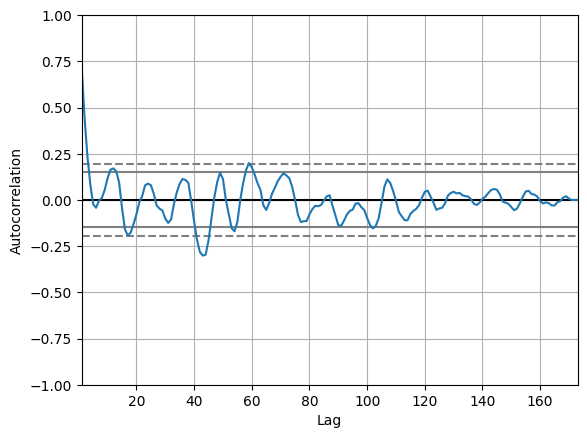

In [6]:
x = df['gaze_height']
acr_plot(x)
plt.show()

### Interpretation of the autocorrelation plot
There's a very high correlation initially, at around lag=1, which suggests tat the series is somewhat
predictable in the short term.

The oscillating pattern suggests possible cyclical or seasonal pattern where the series has periods 
of positive and negative correlation over time.

The oscillations or cycles represent yearly trend in data. There are 13-14 cycles(peaks or troughs)
which correspond to the data being collected between 2010 - 2024.

we can observe that after about 1000 lags, the correlation is extremely low


In [7]:
# Let's fit an ARIMA model and plot residual errors

from statsmodels.tsa.arima.model import ARIMA

In [8]:
train = x
model = ARIMA(train, order=(13,5,5)) #lag p=1000; difference d=1; error dependency q=0 

In [9]:
model_fit = model.fit()

/Users/cuser/Documents/cybertraining/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/cuser/Documents/cybertraining/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:            gaze_height   No. Observations:                  173
Model:                ARIMA(13, 5, 5)   Log Likelihood                -359.296
Date:                Fri, 08 Nov 2024   AIC                            756.592
Time:                        11:36:57   BIC                            815.947
Sample:                             0   HQIC                           780.681
                                - 173                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -3.9608      0.146    -27.140      0.000      -4.247      -3.675
ar.L2         -7.9655      0.547    -14.561      0.000      -9.038      -6.893
ar.L3        -11.0365      1.090    -10.127      0.0

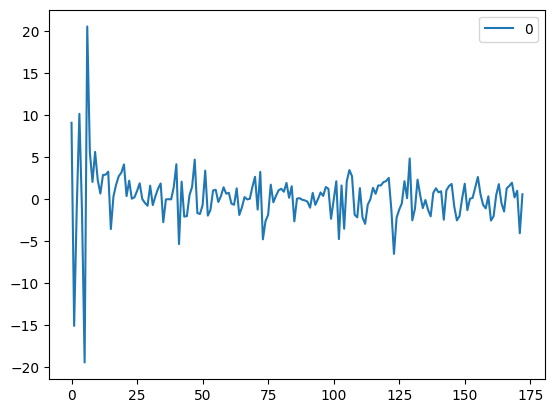

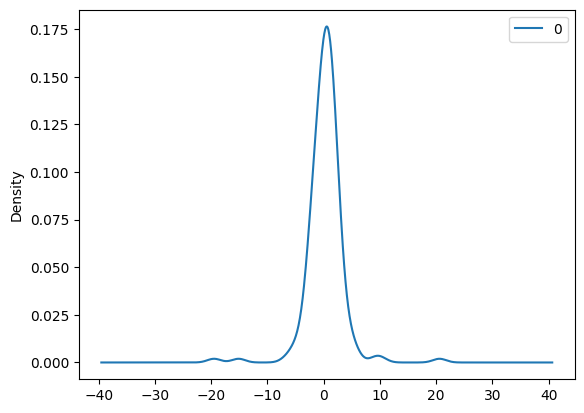

                0
count  173.000000
mean     0.268008
std      3.316734
min    -19.494445
25%     -1.042511
50%      0.332153
75%      1.591247
max     20.580815


In [10]:
#summary of fit model
print(model_fit.summary())
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind = 'kde')
plt.show()
print(residuals.describe())


The first graph is a line plot of the residual erros, suggesting that
there's not much trend in information after a big spike in the begining

The second graph is a density plot of the residual error values, suggesting
the errors are Gaussian with mean close to zero.


In [11]:
df

,DATE,Precip,DryBulbTemp,RelHumidity,Stationpressure,WetBulbTemp,WindSpeed,gaze_height
0,2010-01-31,3.5725,37.428763,65.887097,29.197970,33.213710,5.994624,9.097056
1,2010-02-28,3.7200,39.250000,64.923333,29.088883,34.478333,6.465000,12.159967
2,2010-03-31,4.5300,50.176550,66.549865,29.040889,44.412399,5.607817,9.677655
3,2010-04-30,2.4025,64.012500,61.108333,29.128347,55.183333,4.161111,6.249833
4,2010-05-31,7.1425,72.428763,70.340054,29.130161,65.360215,4.559140,8.520766
...,...,...,...,...,...,...,...,...
168,2024-01-31,5.1750,42.142473,69.212366,29.205188,38.000000,6.055108,6.605524
169,2024-02-29,2.8150,50.654179,60.167147,29.132104,43.870317,5.454611,7.172291
170,2024-03-31,6.1975,56.879567,64.625169,29.125900,50.017591,5.625169,9.395372
171,2024-04-30,2.5300,63.475661,65.098748,29.137733,56.084840,5.605702,6.534159


Test RMSE: 1.464


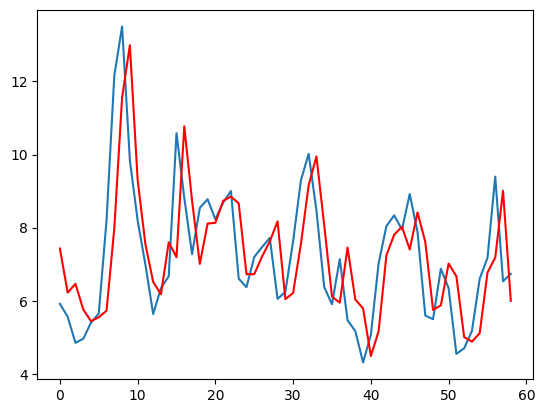

'Add root mean square inside plot itself'

In [6]:
# evaluate an ARIMA model using a walk-forward validation.
# this looks more like a simulation than a prediction, it's slow.

# it's basically fiting model everytime new observation is made and making prediction for next day
# it's using all previous values for fitting data which makes it very slow


from pandas import read_csv
from datetime import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
# load dataset

# it  selects gauge height column from the dataframe, which is also a dataframe
series = df['gaze_height']
# split into train and test sets
X = series.values

# We use 66% (2/3rd) of the data for training and rest is used for testing
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]

# We use all previous data from the given point in time as history to fit the model and make prediction
history = [x for x in train]
predictions = list()

''' Add validation code here'''

for t in range(len(test)): 
 # we pass the hyperparameters p=5, d=1 and q=0 in the function. p,d,q are described above.
 model = ARIMA(history, order=(5,1,0))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output[0]
 predictions.append(yhat)
 obs = test[t]
 history.append(obs)
 #print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts


rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()
'''Add root mean square inside plot itself'''
# Add nse, wape and mae metrics. remove rmse.

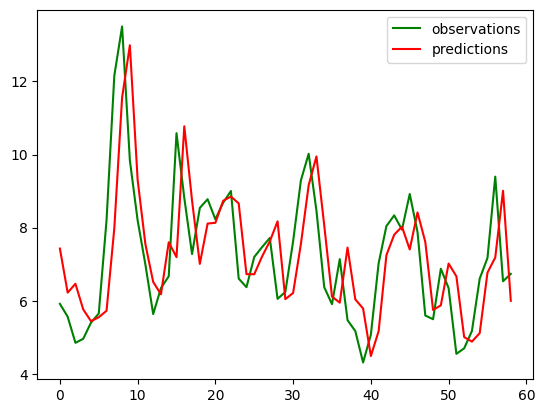

In [7]:
x = range(len(test))
pyplot.plot( test[:100], color='green', label='observations')
pyplot.plot(predictions[:100], color='red', linestyle='-', label='predictions')
pyplot.legend()
pyplot.show()


In [8]:
from datetime import datetime
d = datetime.now()


In [9]:
import numpy as np

epsilon = np.finfo(float).eps

def Wape(y, y_pred):
    """Weighted Average Percentage Error metric in the interval [0; 100]"""
    nominator = np.sum(np.abs(np.subtract(y, y_pred)))
    denominator = np.add(np.sum(np.abs(y)), epsilon)
    wape = np.divide(nominator, denominator)*100.0
    return wape

def nse(y, y_pred):
    return (1-(np.sum((y_pred-y)**2)/np.sum((y-np.mean(y))**2)))

In [11]:
wape = Wape(test.flatten(), predictions)
nsee = nse(test.flatten(), predictions)
print(f'WAPE: {wape}, Nse: {nsee}')

'''Also add Mean Absolute Error'''

WAPE: 15.91989448303042, Nse: 0.3598245626935327


'Also add Mean Absolute Error'

In [17]:
def parse_datetime(date_str):
    # Parse the full datetime string including hours, minutes, seconds, and microseconds
    full_date = datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S.%f')
    
    # Zero out the minutes, seconds, and microseconds
    adjusted_date = full_date.replace(minute=0, second=0, microsecond=0)
    
    return adjusted_date

parse_datetime(str(d))

datetime.datetime(2024, 11, 8, 11, 0)

In [18]:
def difference(series):
    new_series = []
    prev = series[0]
    for nextv in series[1:]:
        new_series.append(nextv-prev)
        prev = nextv
    return np.array(new_series)

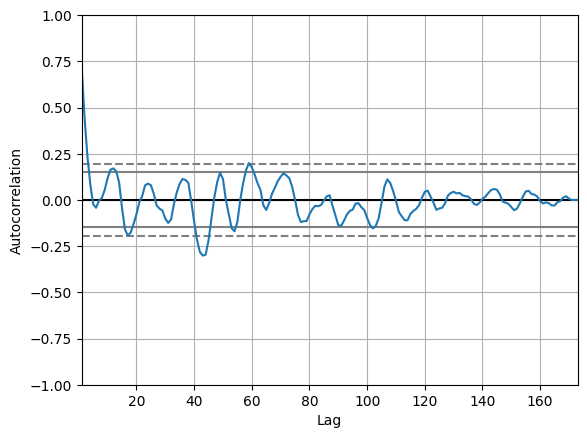

(172,)


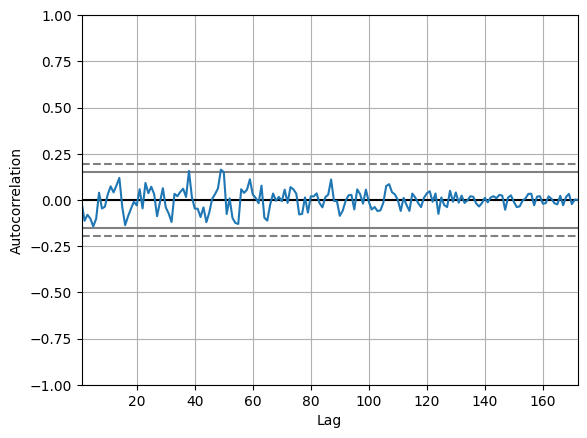

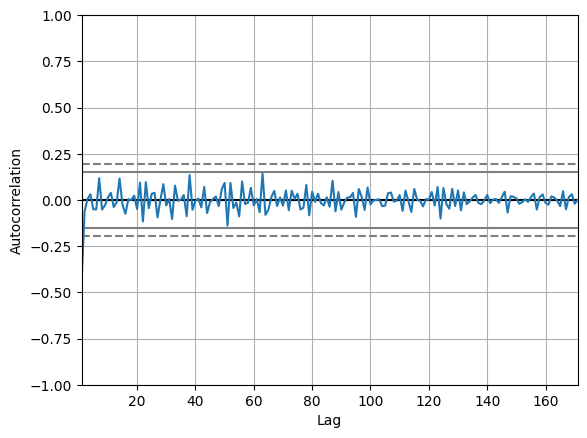

In [19]:
y = np.array(df['gaze_height']).flatten()
acr_plot(y)
plt.show()
first_diff = difference(y)
print(first_diff.shape)
acr_plot(first_diff)
plt.show()
second_diff = difference(first_diff)
acr_plot(second_diff)
plt.show()

In [20]:
# limitations of arima modeling
'''
It's good when we have less data.
Doesn't capture information from large amount of data.
Forecasting is slow.
'''

"\nIt's good when we have less data.\nDoesn't capture information from large amount of data.\nForecasting is slow.\n"